# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.

# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
#importing the required libraries
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns
import pandas as pd
import sqlite3
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from scipy.linalg import eigh
import re
from gensim.models import word2vec
import pickle
from gensim.models import KeyedVectors
import string
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from gensim.models import Word2Vec
from sklearn import decomposition
pca = decomposition.PCA()
from sklearn.manifold import TSNE
from scipy.sparse import csc_matrix
from scipy.sparse import csr_matrix
from tqdm import tqdm
import string
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
#from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
#from sklearn import cross_validation
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import label_binarize
from prettytable import PrettyTable
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.decomposition import TruncatedSVD
from sklearn.utils import resample
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from mpl_toolkits.mplot3d import axes3d
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.decomposition import TruncatedSVD
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [0]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 5000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (5000, 10)


Id   ProductId          UserId                      ProfileName  \
0   1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
1   2  B00813GRG4  A1D87F6ZCVE5NK                           dll pa   
2   3  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     1                       1      1  1303862400   
1                     0                       0      0  1346976000   
2                     1                       1      1  1219017600   

                 Summary                                               Text  
0  Good Quality Dog Food  I have bought several of the Vitality canned d...  
1      Not as Advertised  Product arrived labeled as Jumbo Salted Peanut...  
2  "Delight" says it all  This is a confection that has been around a fe...

In [0]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [0]:
print(display.shape)
display.head()

(80668, 7)


UserId   ProductId             ProfileName        Time  Score  \
0  #oc-R115TNMSPFT9I7  B007Y59HVM                 Breyton  1331510400      2   
1  #oc-R11D9D7SHXIJB9  B005HG9ET0  Louis E. Emory "hoppy"  1342396800      5   
2  #oc-R11DNU2NBKQ23Z  B007Y59HVM        Kim Cieszykowski  1348531200      1   
3  #oc-R11O5J5ZVQE25C  B005HG9ET0           Penguin Chick  1346889600      5   
4  #oc-R12KPBODL2B5ZD  B007OSBE1U   Christopher P. Presta  1348617600      1   

                                                Text  COUNT(*)  
0  Overall its just OK when considering the price...         2  
1  My wife has recurring extreme muscle spasms, u...         3  
2  This coffee is horrible and unfortunately not ...         2  
3  This will be the bottle that you grab from the...         3  
4  I didnt like this coffee. Instead of telling y...         2

In [0]:
display[display['UserId']=='AZY10LLTJ71NX']

UserId   ProductId                      ProfileName        Time  \
80638  AZY10LLTJ71NX  B006P7E5ZI  undertheshrine "undertheshrine"  1334707200   

       Score                                               Text  COUNT(*)  
80638      5  I was recommended to try green tea extract to ...         5

In [0]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [0]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

Id   ProductId         UserId      ProfileName  HelpfulnessNumerator  \
0   78445  B000HDL1RQ  AR5J8UI46CURR  Geetha Krishnan                     2   
1  138317  B000HDOPYC  AR5J8UI46CURR  Geetha Krishnan                     2   
2  138277  B000HDOPYM  AR5J8UI46CURR  Geetha Krishnan                     2   
3   73791  B000HDOPZG  AR5J8UI46CURR  Geetha Krishnan                     2   
4  155049  B000PAQ75C  AR5J8UI46CURR  Geetha Krishnan                     2   

   HelpfulnessDenominator  Score        Time  \
0                       2      5  1199577600   
1                       2      5  1199577600   
2                       2      5  1199577600   
3                       2      5  1199577600   
4                       2      5  1199577600   

                             Summary  \
0  LOACKER QUADRATINI VANILLA WAFERS   
1  LOACKER QUADRATINI VANILLA WAFERS   
2  LOACKER QUADRATINI VANILLA WAFERS   
3  LOACKER QUADRATINI VANILLA WAFERS   
4  LOACKER QUADRATINI VANILLA WAFERS   

                                                Text  
0  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...  
1  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...  
2  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...  
3  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...  
4  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...

As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [0]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [0]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(4986, 10)

In [0]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

99.72

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [0]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

Id   ProductId          UserId              ProfileName  \
0  64422  B000MIDROQ  A161DK06JJMCYF  J. E. Stephens "Jeanne"   
1  44737  B001EQ55RW  A2V0I904FH7ABY                      Ram   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     3                       1      5  1224892800   
1                     3                       2      4  1212883200   

                                        Summary  \
0             Bought This for My Son at College   
1  Pure cocoa taste with crunchy almonds inside   

                                                Text  
0  My son loves spaghetti so I didn't hesitate or...  
1  It was almost a 'love at first bite' - the per...

In [0]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [0]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(4986, 10)


1    4178
0     808
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [0]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

Why is this $[...] when the same product is available for $[...] here?<br />http://www.amazon.com/VICTOR-FLY-MAGNET-BAIT-REFILL/dp/B00004RBDY<br /><br />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.
I recently tried this flavor/brand and was surprised at how delicious these chips are.  The best thing was that there were a lot of "brown" chips in the bsg (my favorite), so I bought some more through amazon and shared with family and friends.  I am a little disappointed that there are not, so far, very many brown chips in these bags, but the flavor is still very good.  I like them better than the yogurt and green onion flavor because they do not seem to be as salty, and the onion flavor is better.  If you haven't eaten Kettle chips before, I recommend that you try a bag before buying bulk.  They are thicker and crunchier than Lays but just as fresh out of the bag.
Wow.  So far, two two-star reviews.  One obviously had no 

In [0]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

Why is this $[...] when the same product is available for $[...] here?<br /> /><br />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.


In [0]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

Why is this $[...] when the same product is available for $[...] here? />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.
I recently tried this flavor/brand and was surprised at how delicious these chips are.  The best thing was that there were a lot of "brown" chips in the bsg (my favorite), so I bought some more through amazon and shared with family and friends.  I am a little disappointed that there are not, so far, very many brown chips in these bags, but the flavor is still very good.  I like them better than the yogurt and green onion flavor because they do not seem to be as salty, and the onion flavor is better.  If you haven't eaten Kettle chips before, I recommend that you try a bag before buying bulk.  They are thicker and crunchier than Lays but just as fresh out of the bag.
Wow.  So far, two two-star reviews.  One obviously had no idea what they were ordering; the other wants crispy cookies.  Hey, I'm sorry; b

In [0]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [0]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

Wow.  So far, two two-star reviews.  One obviously had no idea what they were ordering; the other wants crispy cookies.  Hey, I am sorry; but these reviews do nobody any good beyond reminding us to look  before ordering.<br /><br />These are chocolate-oatmeal cookies.  If you do not like that combination, do not order this type of cookie.  I find the combo quite nice, really.  The oatmeal sort of "calms" the rich chocolate flavor and gives the cookie sort of a coconut-type consistency.  Now let is also remember that tastes differ; so, I have given my opinion.<br /><br />Then, these are soft, chewy cookies -- as advertised.  They are not "crispy" cookies, or the blurb would say "crispy," rather than "chewy."  I happen to like raw cookie dough; however, I do not see where these taste like raw cookie dough.  Both are soft, however, so is this the confusion?  And, yes, they stick together.  Soft cookies tend to do that.  They are not individually wrapped, which would add to the cost.  Oh y

In [0]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

Why is this $[...] when the same product is available for $[...] here?<br /> /><br />The Victor  and  traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.


In [0]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

Wow So far two two star reviews One obviously had no idea what they were ordering the other wants crispy cookies Hey I am sorry but these reviews do nobody any good beyond reminding us to look before ordering br br These are chocolate oatmeal cookies If you do not like that combination do not order this type of cookie I find the combo quite nice really The oatmeal sort of calms the rich chocolate flavor and gives the cookie sort of a coconut type consistency Now let is also remember that tastes differ so I have given my opinion br br Then these are soft chewy cookies as advertised They are not crispy cookies or the blurb would say crispy rather than chewy I happen to like raw cookie dough however I do not see where these taste like raw cookie dough Both are soft however so is this the confusion And yes they stick together Soft cookies tend to do that They are not individually wrapped which would add to the cost Oh yeah chocolate chip cookies tend to be somewhat sweet br br So if you wa

In [0]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [0]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 4986/4986 [00:01<00:00, 2674.74it/s]


In [0]:
preprocessed_reviews[1500]

'wow far two two star reviews one obviously no idea ordering wants crispy cookies hey sorry reviews nobody good beyond reminding us look ordering chocolate oatmeal cookies not like combination not order type cookie find combo quite nice really oatmeal sort calms rich chocolate flavor gives cookie sort coconut type consistency let also remember tastes differ given opinion soft chewy cookies advertised not crispy cookies blurb would say crispy rather chewy happen like raw cookie dough however not see taste like raw cookie dough soft however confusion yes stick together soft cookies tend not individually wrapped would add cost oh yeah chocolate chip cookies tend somewhat sweet want something hard crisp suggest nabiso ginger snaps want cookie soft chewy tastes like combination chocolate oatmeal give try place second order'

# [5] Assignment 10: K-Means, Agglomerative & DBSCAN Clustering

<ol>
    <li><strong>Apply K-means Clustering on these feature sets:</strong>
        <ul>
    <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
    <li>Find the best ‘k’ using the elbow-knee method (plot k vs inertia_)</li>
    <li>Once after you find the k clusters, plot the word cloud per each cluster so that at a single
go we can analyze the words in a cluster.</li>          
        </ul>
    </li>
    <br>
    <li><strong>Apply Agglomerative Clustering on these feature sets:</strong>
        <ul>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
    <li>Apply agglomerative algorithm and try a different number of clusters like 2,5 etc.</li>
    <li>Same as that of K-means, plot word clouds for each cluster and summarize in your own words what that cluster is representing.</li>
            <li>You can take around 5000 reviews or so(as this is very computationally expensive one)</li>
        </ul>
    </li>
    <br>
    <br>
    <li><strong>Apply DBSCAN Clustering on these feature sets:</strong>
        <ul>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
    <li>Find the best ‘Eps’ using the <a href='https://stackoverflow.com/questions/12893492/choosing-eps-and-minpts-for-dbscan-r/48558030#48558030'>elbow-knee method.</a></li>
    <li>Same as before, plot word clouds for each cluster and summarize in your own words what that cluster is representing.</li>
            <li>You can take around 5000 reviews for this as well.</li>
        </ul>
    </li>
</ol>

# BOW on the data

In [0]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(preprocessed_reviews)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

final_counts = count_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

some feature names  ['aa', 'aahhhs', 'aback', 'abandon', 'abates', 'abbott', 'abby', 'abdominal', 'abiding', 'ability']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (4986, 12997)
the number of unique words  12997


# [1] BOW

In [0]:
inertia = []
k = []
for i in tqdm(range(30)):
  if i != 0:
    kmeans = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=300, tol=0.0001, n_jobs=-1).fit(final_counts)
    inertia.append(kmeans.inertia_)
    k.append(i)

100%|██████████| 30/30 [19:40<00:00, 47.68s/it]


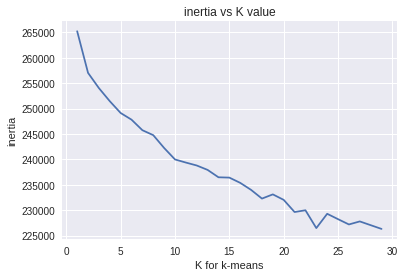

In [0]:

plt.plot(k, inertia)
plt.title('inertia vs K value')
plt.ylabel('inertia')
plt.xlabel('K for k-means')
plt.show()

## From the above graph we can infer that the right value for K must be 23, now getting the silhouette_score.

In [0]:
clusterer = KMeans(n_clusters=23, init='k-means++', n_init=10, max_iter=300, tol=0.0001, n_jobs=-1)
cluster_labels = clusterer.fit_predict(final_counts)
silhouette_avg = silhouette_score(final_counts, cluster_labels)
print("For n_clusters =", 23, "The average silhouette_score is :", silhouette_avg)

For n_clusters = 23 The average silhouette_score is : 0.05830859034363628


## Now visualizing the clusters in 2-D and 3-D.

In [0]:
svd = TruncatedSVD(n_components=12996)
final_counts = svd.fit_transform(final_counts)

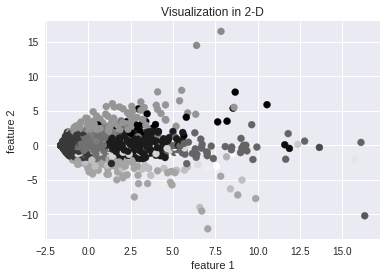

In [0]:

pca = PCA(n_components=2).fit(final_counts)
pca_2d = pca.transform(final_counts)
kmeans = KMeans(n_clusters=23, init='k-means++', n_init=10, max_iter=300, tol=0.0001, n_jobs=-1)
kmeans.fit(final_counts)
plt.figure()
plt.scatter(pca_2d[:, 0], pca_2d[:, 1], c=kmeans.labels_)
plt.title('Visualization in 2-D')
plt.ylabel('feature 2')
plt.xlabel('feature 1')
plt.show()


In [0]:
k_means = KMeans(n_clusters=23, init='k-means++', n_init=10, max_iter=300, tol=0.0001, n_jobs=-1)
k_means.fit(final_counts)
k_means_predicted = k_means.predict(final_counts)
centroids = k_means.cluster_centers_
X = final_counts
y = k_means.labels_
print(X.shape)
print(y.shape)


(4986, 4986)
(4986,)


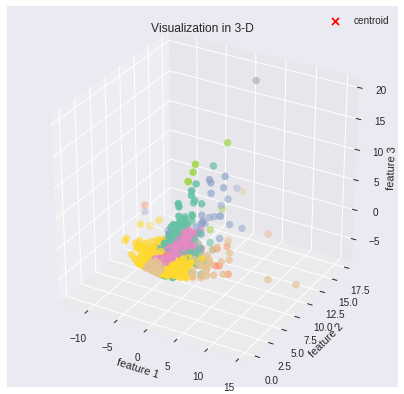

In [0]:
%matplotlib inline

#colors = ['navy', 'turquoise', 'darkorange']
plt.figure('K-Means on given Dataset', figsize=(7,7))
ax = plt.axes(projection = '3d')
ax.scatter(X[:,3],X[:,0],X[:,2], c=y , cmap='Set2', s=50)
plt.title('Visualization in 3-D')
ax.set_xlabel('feature 1')
ax.set_ylabel('feature 2')
ax.set_zlabel('feature 3')
ax.legend()
plt.show()

## Getting the top words from each cluster and generting the word cloud for reviews for some of the clusters.



In [0]:
print("Top terms per cluster:")
print()
order_centroids = clusterer.cluster_centers_.argsort()[:, ::-1]
terms = count_vect.get_feature_names()
for i in range(clusterer.n_clusters):
    print("Cluster %d:" % i, end='')
    for ind in order_centroids[i, :15]:
        print(' %s' % terms[ind], end='')
    print()


Top terms per cluster:

Cluster 0: not product food corn dog icicle ingredients windows meat calcium amazon still no one blue
Cluster 1: water not like product coconut use one add taste good get drink great would also
Cluster 2: chips not kettle potato like bag flavor salt bags great good taste brand chip would
Cluster 3: food dog not newman one organic would like dogs good bag old no eat foods
Cluster 4: not bisquick mix flour box gluten free rice biscuits recipe baking gum make use xanthan
Cluster 5: tea not green like water taste flavor one good teas drink bag use sweet iced
Cluster 6: food not eating day would little no got really whatever three around cat back always
Cluster 7: egg calcium allergy baby yolk phosphorus formula organic foods dha also white infant ratio not
Cluster 8: raw cacao aware alive amazon not different price know coconut like oil powder reviews saquin
Cluster 9: oreo mini nabisco chocolate cakesters cream not calories calorie cookie one packs two eating filli

In [0]:
def Word_Cloud(X, number_of_clusters):
  model = KMeans(n_clusters=number_of_clusters, init='k-means++', n_init=10, max_iter=300, tol=0.0001, n_jobs=-1)
  model.fit(X)
  labels = list(model.labels_)
  print('Printing the Word Cloud only for 5 clusters')
  print()
  for x in range(0, 5):
    def lists(x, labels):
      cluster = []
      for i in range(0, len(labels)):
        if labels[i]==x:
          cluster.append(i)
      return cluster
    datapoint_index = lists(x, labels)
    
    list_of_words = []
    for j in datapoint_index:
      for sent in preprocessed_reviews[j].split(' '):
        list_of_words.append(sent)
    print('Cluster'+' '+str(x+1))
    features_str = ' '.join(list_of_words)
    wordcloud = WordCloud(width = 1000, height = 500).generate(features_str)

    plt.figure(figsize=(10,10))
    plt.imshow(wordcloud)
    plt.axis("off")
    #plt.savefig("tfidf_RF"+".png", bbox_inches='tight')
    plt.show()
    plt.close()

Printing the Word Cloud only for 5 clusters

Cluster 1


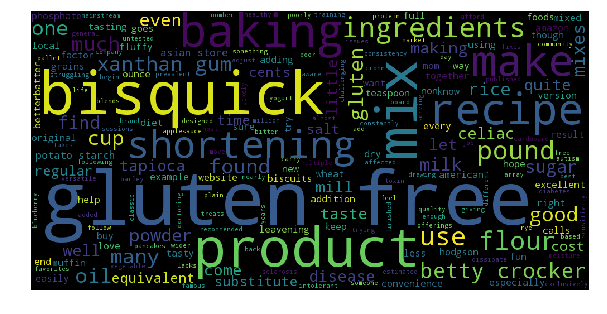

Cluster 2


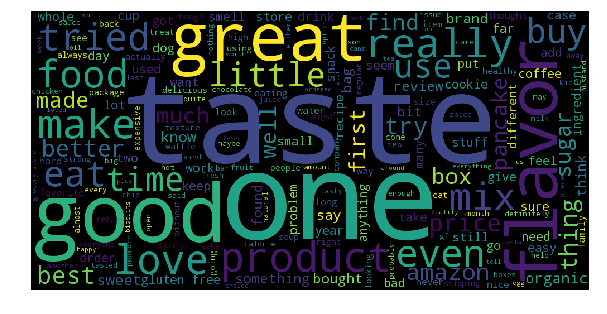

Cluster 3


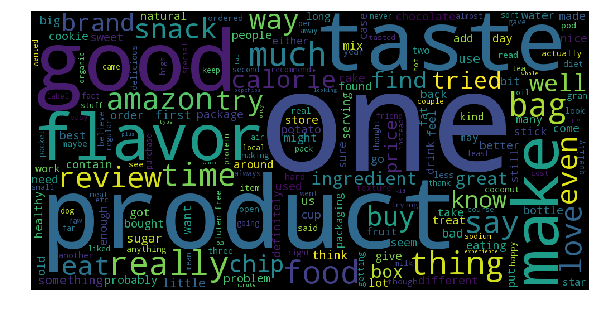

Cluster 4


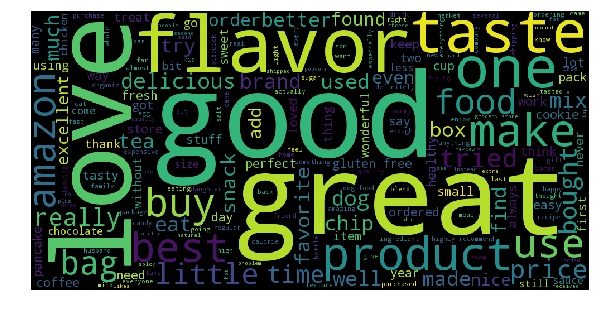

Cluster 5


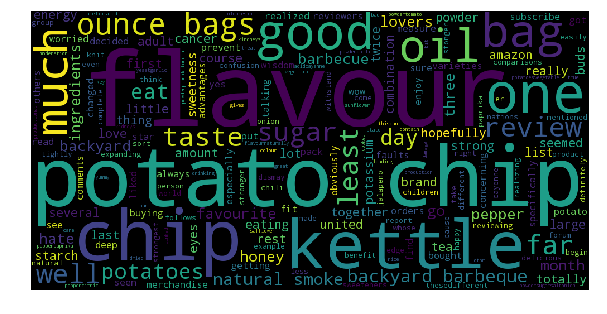

In [0]:
Word_Cloud(final_counts, 23)

# TF-IDF on the data

In [0]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(preprocessed_reviews)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

final_tf_idf = tf_idf_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

some sample features(unique words in the corpus) ['ability', 'able', 'able find', 'able get', 'absolute', 'absolutely', 'absolutely delicious', 'absolutely love', 'absolutely no', 'according']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (4986, 3144)
the number of unique words including both unigrams and bigrams  3144


# [2] TF-IDF

In [0]:
inertia = []
k = []
for i in tqdm(range(30)):
  if i != 0:
    kmeans = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=300, tol=0.0001, n_jobs=-1).fit(final_tf_idf)
    inertia.append(kmeans.inertia_)
    k.append(i)

100%|██████████| 30/30 [19:17<00:00, 46.97s/it]


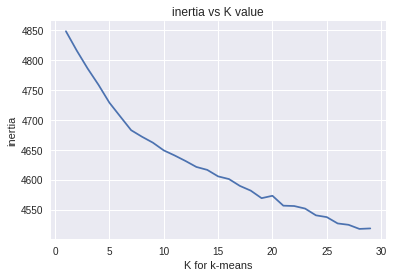

In [0]:
plt.plot(k, inertia)
plt.title('inertia vs K value')
plt.ylabel('inertia')
plt.xlabel('K for k-means')
plt.show()

## From the above graph we can infer that the right value for K must be 21, now getting the silhouette_score.

In [0]:
clusterer = KMeans(n_clusters=21, init='k-means++', n_init=10, max_iter=300, tol=0.0001, n_jobs=-1)
cluster_labels = clusterer.fit_predict(final_tf_idf)
silhouette_avg = silhouette_score(final_tf_idf, cluster_labels)
print("For n_clusters =", 21, "The average silhouette_score is :", silhouette_avg)

For n_clusters = 21 The average silhouette_score is : 0.01787083385907614


## Now visualizing the clusters in 2-D and 3-D.

In [0]:
svd = TruncatedSVD(n_components=3143)
final_counts = svd.fit_transform(final_tf_idf)

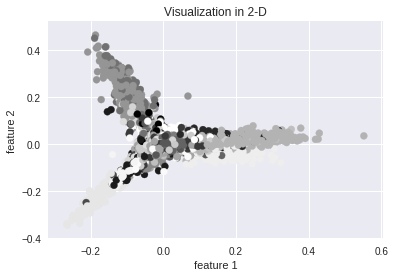

In [0]:
pca = PCA(n_components=2).fit(final_counts)
pca_2d = pca.transform(final_counts)
kmeans = KMeans(n_clusters=21, init='k-means++', n_init=10, max_iter=300, tol=0.0001, n_jobs=-1)
kmeans.fit(final_counts)
plt.figure()
plt.scatter(pca_2d[:, 0], pca_2d[:, 1], c=kmeans.labels_)
plt.title('Visualization in 2-D')
plt.ylabel('feature 2')
plt.xlabel('feature 1')
plt.show()


In [0]:
k_means = KMeans(n_clusters=21, init='k-means++', n_init=10, max_iter=300, tol=0.0001, n_jobs=-1)
k_means.fit(final_counts)
k_means_predicted = k_means.predict(final_counts)
centroids = k_means.cluster_centers_
X = final_counts
y = k_means.labels_
print(X.shape)
print(y.shape)


(4986, 3143)
(4986,)


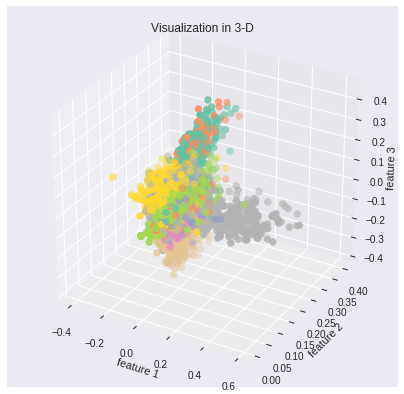

In [0]:
%matplotlib inline

#colors = ['navy', 'turquoise', 'darkorange']
plt.figure('K-Means on given Dataset', figsize=(7,7))
ax = plt.axes(projection = '3d')
ax.scatter(X[:,3],X[:,0],X[:,2], c=y , cmap='Set2', s=50)
plt.title('Visualization in 3-D')
ax.set_xlabel('feature 1')
ax.set_ylabel('feature 2')
ax.set_zlabel('feature 3')

plt.show()

## Getting the top words from each cluster and generting the word cloud for reviews for some of the clusters.


In [0]:
print("Top terms per cluster:")
print()
order_centroids = clusterer.cluster_centers_.argsort()[:, ::-1]
terms = tf_idf_vect.get_feature_names()
for i in range(clusterer.n_clusters):
    print("Cluster %d:" % i, end='')
    for ind in order_centroids[i, :15]:
        print(' %s' % terms[ind], end='')
    print()

Top terms per cluster:

Cluster 0: bag bags not box chips one good size love whole like great small open whole bag
Cluster 1: chocolate hot cocoa hot chocolate cup hot cocoa cups keurig not dark dark chocolate taste milk grove good
Cluster 2: tea green green tea not like teas iced drink love taste water flavor good iced tea drinking
Cluster 3: salt vinegar chips salt vinegar pepper salt pepper sea salt sea flavors flavor not favorite like bbq love
Cluster 4: not one would like eat good no food cat get taste cats could much time
Cluster 5: mix pancakes waffles pancake waffle gf not make recipe pancake mix bisquick made family use waffle mix
Cluster 6: coffee not cup decaf taste like smooth bitter good cup coffee strong one flavor dark roast
Cluster 7: gluten gluten free free bisquick pancakes mix not biscuits make good gf product great made baking
Cluster 8: sauce oil chicken pasta hot use not flavor fish good sweet add heat love seasoning
Cluster 9: store local grocery stores grocery s

In [0]:
def Word_Cloud(X, number_of_clusters):
  model = KMeans(n_clusters=number_of_clusters, init='k-means++', n_init=10, max_iter=300, tol=0.0001, n_jobs=-1)
  model.fit(X)
  labels = list(model.labels_)
  print('Printing the Word Cloud only for 5 clusters')
  print()
  for x in range(0, 5):
    def lists(x, labels):
      cluster = []
      for i in range(0, len(labels)):
        if labels[i]==x:
          cluster.append(i)
      return cluster
    datapoint_index = lists(x, labels)
    
    list_of_words = []
    for j in datapoint_index:
      for sent in preprocessed_reviews[j].split(' '):
        list_of_words.append(sent)
    print('Cluster'+' '+str(x+1))
    features_str = ' '.join(list_of_words)
    wordcloud = WordCloud(width = 1000, height = 500).generate(features_str)

    plt.figure(figsize=(10,10))
    plt.imshow(wordcloud)
    plt.axis("off")
    #plt.savefig("tfidf_RF"+".png", bbox_inches='tight')
    plt.show()
    plt.close()

Printing the Word Cloud only for 5 clusters

Cluster 1


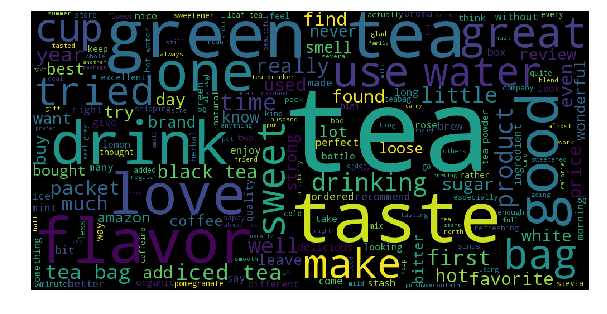

Cluster 2


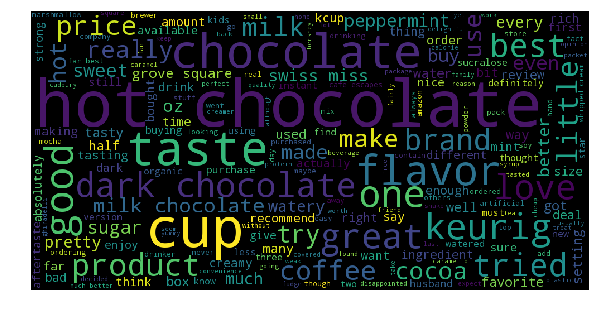

Cluster 3


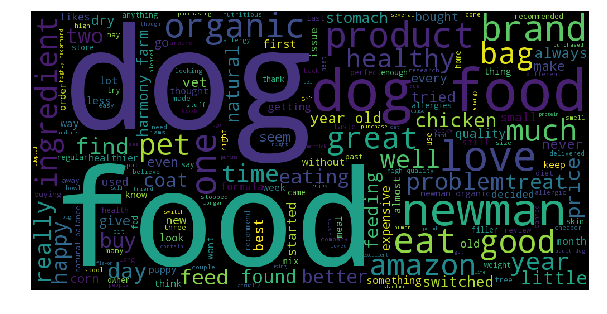

Cluster 4


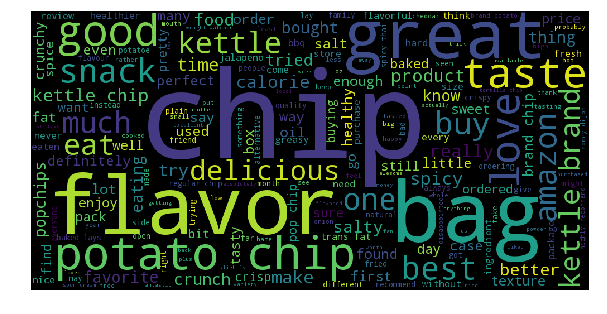

Cluster 5


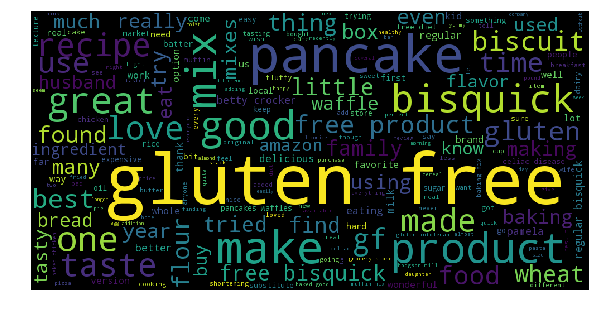

In [0]:
Word_Cloud(final_tf_idf, 21)

# Average W2V on the data

In [0]:
i=0
list_of_sentance=[]
for sentance in preprocessed_reviews:
    list_of_sentance.append(sentance.split())

In [0]:
w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
print(w2v_model.wv.most_similar('great'))
print('='*50)
print(w2v_model.wv.most_similar('worst'))

[('tasty', 0.9953232407569885), ('alternative', 0.9941218495368958), ('wonderful', 0.993924617767334), ('enjoy', 0.9936097264289856), ('tasting', 0.993596613407135), ('satisfying', 0.9935389161109924), ('salty', 0.9934831857681274), ('crisp', 0.9934453368186951), ('excellent', 0.993443489074707), ('crispy', 0.9934421181678772)]
[('popcorn', 0.9994726181030273), ('awful', 0.9994354248046875), ('beef', 0.9993987083435059), ('wow', 0.9993581175804138), ('oatmeal', 0.9993494153022766), ('de', 0.9993181824684143), ('gourmet', 0.9993038773536682), ('dinner', 0.9992845058441162), ('varieties', 0.9992735981941223), ('goes', 0.9992726445198059)]


In [0]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  3817
sample words  ['product', 'available', 'course', 'total', 'pretty', 'stinky', 'right', 'nearby', 'used', 'ca', 'not', 'beat', 'great', 'received', 'shipment', 'could', 'hardly', 'wait', 'try', 'love', 'call', 'instead', 'removed', 'easily', 'daughter', 'designed', 'printed', 'use', 'car', 'windows', 'beautifully', 'shop', 'program', 'going', 'lot', 'fun', 'everywhere', 'like', 'tv', 'computer', 'really', 'good', 'idea', 'final', 'outstanding', 'window', 'everybody', 'asks', 'bought', 'made']


In [0]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|██████████| 4986/4986 [00:04<00:00, 1218.06it/s]

4986
50


In [0]:
X_avgw2v = np.asarray(sent_vectors)
standardized_vec = StandardScaler(with_mean=False)
# here it will learn mu and sigma
standardized_vec.fit(X_avgw2v)
X_avgw2v = standardized_vec.transform(X_avgw2v)
print(X_avgw2v.shape)


(4986, 50)


# [3] Average W2V.

In [0]:
inertia = []
k = []
for i in tqdm(range(100)):
  if i != 0:
    kmeans = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=300, tol=0.0001, n_jobs=-1).fit(X_avgw2v)
    inertia.append(kmeans.inertia_)
    k.append(i)

100%|██████████| 100/100 [04:15<00:00,  4.22s/it]


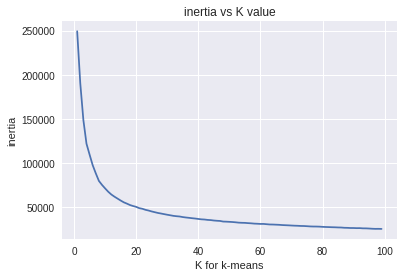

In [0]:
plt.plot(k, inertia)
plt.title('inertia vs K value')
plt.ylabel('inertia')
plt.xlabel('K for k-means')
plt.show()

## From the above graph we can infer that the right value for K must be 50, now getting the silhouette_score.

In [0]:
clusterer = KMeans(n_clusters=50, init='k-means++', n_init=10, max_iter=300, tol=0.0001, n_jobs=-1)
cluster_labels = clusterer.fit_predict(X_avgw2v)
silhouette_avg = silhouette_score(X_avgw2v, cluster_labels)
print("For n_clusters =", 50, "The average silhouette_score is :", silhouette_avg)

For n_clusters = 50 The average silhouette_score is : 0.14590702133003144


## Now visualizing the clusters in 2-D and 3-D.

In [0]:
final_counts = X_avgw2v

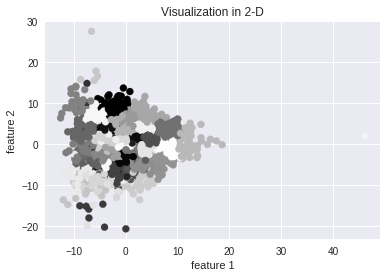

In [0]:
pca = PCA(n_components=2).fit(final_counts)
pca_2d = pca.transform(final_counts)
kmeans = KMeans(n_clusters=50, init='k-means++', n_init=10, max_iter=300, tol=0.0001, n_jobs=-1)
kmeans.fit(final_counts)
plt.figure()
plt.scatter(pca_2d[:, 0], pca_2d[:, 1], c=kmeans.labels_)
plt.title('Visualization in 2-D')
plt.ylabel('feature 2')
plt.xlabel('feature 1')
plt.show()


In [0]:
k_means = KMeans(n_clusters=50, init='k-means++', n_init=10, max_iter=300, tol=0.0001, n_jobs=-1)
k_means.fit(final_counts)
k_means_predicted = k_means.predict(final_counts)
centroids = k_means.cluster_centers_
X = final_counts
y = k_means.labels_
print(X.shape)
print(y.shape)


(4986, 50)
(4986,)


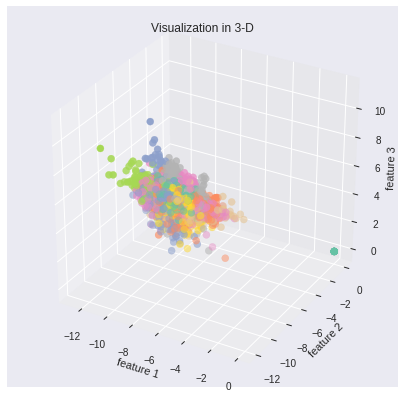

In [0]:
%matplotlib inline

#colors = ['navy', 'turquoise', 'darkorange']
plt.figure('K-Means on given Dataset', figsize=(7,7))
ax = plt.axes(projection = '3d')
ax.scatter(X[:,3],X[:,0],X[:,2], c=y , cmap='Set2', s=50)
plt.title('Visualization in 3-D')
ax.set_xlabel('feature 1')
ax.set_ylabel('feature 2')
ax.set_zlabel('feature 3')

plt.show()

##  Generting the word cloud for reviews for some of the clusters.


In [0]:
def Word_Cloud(X, number_of_clusters):
  model = KMeans(n_clusters=number_of_clusters, init='k-means++', n_init=10, max_iter=300, tol=0.0001, n_jobs=-1)
  model.fit(X)
  labels = list(model.labels_)
  print('Printing the Word Cloud only for 5 clusters')
  print()
  a = [1, 3, 5, 7, 9, 11]
  for x in a:
    def lists(x, labels):
      cluster = []
      for i in range(0, len(labels)):
        if labels[i]==x:
          cluster.append(i)
      return cluster
    datapoint_index = lists(x, labels)
    
    list_of_words = []
    for j in datapoint_index:
      for sent in preprocessed_reviews[j].split(' '):
        list_of_words.append(sent)
    print('Cluster'+' '+str(x+1))
    features_str = ' '.join(list_of_words)
    wordcloud = WordCloud(width = 1000, height = 500).generate(features_str)

    plt.figure(figsize=(10,10))
    plt.imshow(wordcloud)
    plt.axis("off")
    #plt.savefig("tfidf_RF"+".png", bbox_inches='tight')
    plt.show()
    plt.close()

Printing the Word Cloud only for 5 clusters

Cluster 2


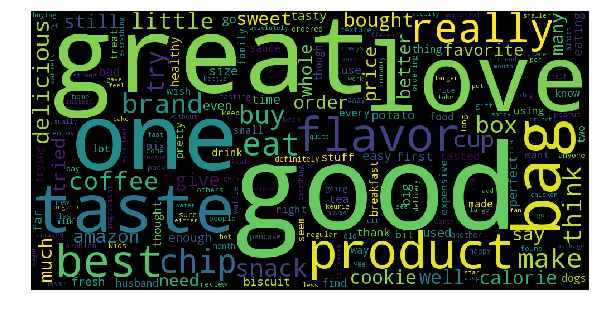

Cluster 4


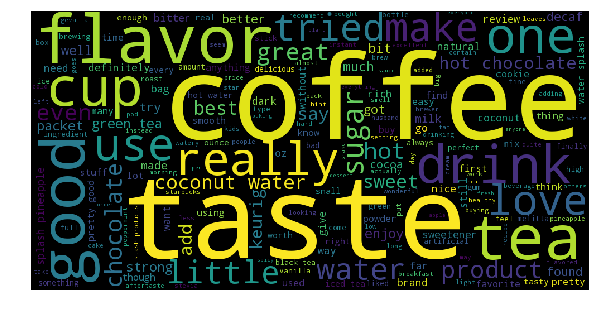

Cluster 6


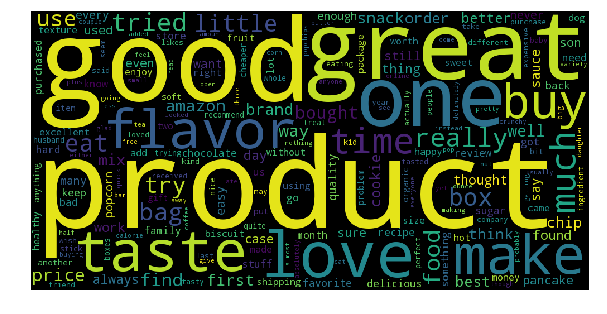

Cluster 8


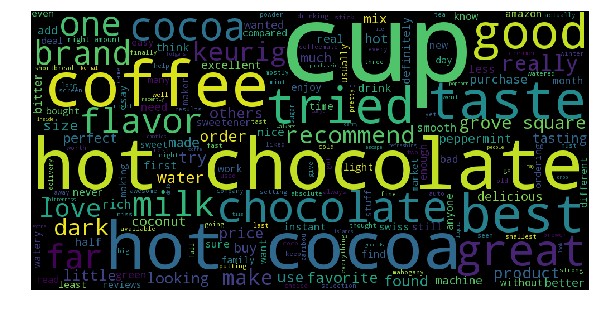

Cluster 10


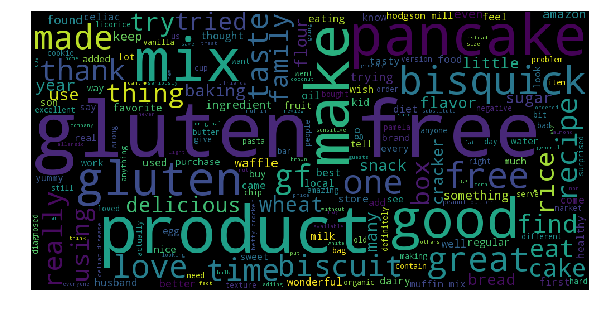

Cluster 12


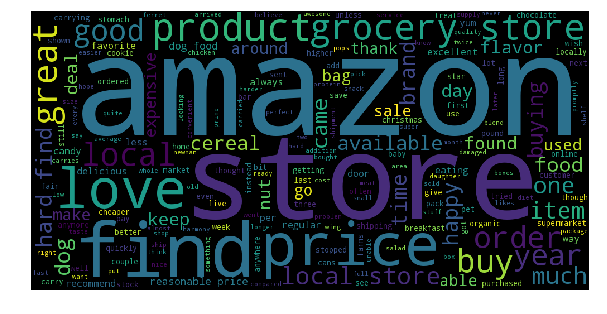

In [0]:
Word_Cloud(X_avgw2v, 50)

# TF-IDF weighted W2V on the data

In [0]:
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(preprocessed_reviews)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [0]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|██████████| 4986/4986 [00:30<00:00, 162.68it/s]


In [0]:
X_tfidfw2v = np.asarray(tfidf_sent_vectors)
standardized_vec = StandardScaler(with_mean=False)
# here it will learn mu and sigma
standardized_vec.fit(X_tfidfw2v)
X_tfidfw2v = standardized_vec.transform(X_tfidfw2v)
print(X_tfidfw2v.shape)

(4986, 50)


# [4] TF-IDF weighted W2V

In [0]:
inertia = []
k = []
for i in tqdm(range(100)):
  if i != 0:
    kmeans = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=300, tol=0.0001, n_jobs=-1).fit(X_tfidfw2v)
    inertia.append(kmeans.inertia_)
    k.append(i)

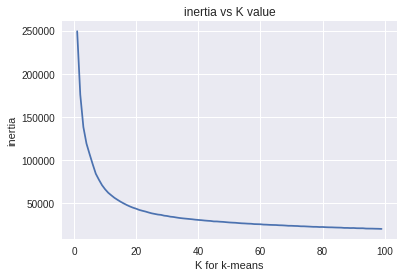

In [0]:
plt.plot(k, inertia)
plt.title('inertia vs K value')
plt.ylabel('inertia')
plt.xlabel('K for k-means')
plt.show()

## From the above graph we can infer that the right value for K must be 50, now getting the silhouette_score.

In [0]:
clusterer = KMeans(n_clusters=50, init='k-means++', n_init=10, max_iter=300, tol=0.0001, n_jobs=-1)
cluster_labels = clusterer.fit_predict(X_tfidfw2v)
silhouette_avg = silhouette_score(X_tfidfw2v, cluster_labels)
print("For n_clusters =", 50, "The average silhouette_score is :", silhouette_avg)

For n_clusters = 50 The average silhouette_score is : 0.16794285868183953


## Now visualizing the clusters in 2-D and 3-D.

In [0]:
final_counts = X_tfidfw2v

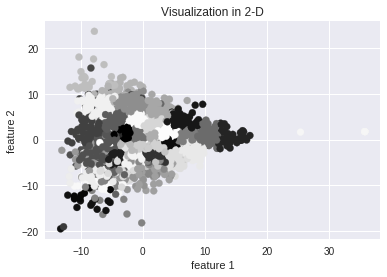

In [0]:
pca = PCA(n_components=2).fit(final_counts)
pca_2d = pca.transform(final_counts)
kmeans = KMeans(n_clusters=50, init='k-means++', n_init=10, max_iter=300, tol=0.0001, n_jobs=-1)
kmeans.fit(final_counts)
plt.figure()
plt.scatter(pca_2d[:, 0], pca_2d[:, 1], c=kmeans.labels_)
plt.title('Visualization in 2-D')
plt.ylabel('feature 2')
plt.xlabel('feature 1')
plt.show()


In [0]:
k_means = KMeans(n_clusters=50, init='k-means++', n_init=10, max_iter=300, tol=0.0001, n_jobs=-1)
k_means.fit(final_counts)
k_means_predicted = k_means.predict(final_counts)
centroids = k_means.cluster_centers_
X = final_counts
y = k_means.labels_
print(X.shape)
print(y.shape)


(4986, 50)
(4986,)


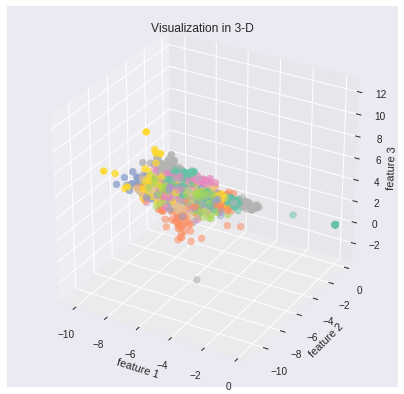

In [0]:
%matplotlib inline

#colors = ['navy', 'turquoise', 'darkorange']
plt.figure('K-Means on given Dataset', figsize=(7,7))
ax = plt.axes(projection = '3d')
ax.scatter(X[:,3],X[:,0],X[:,2], c=y , cmap='Set2', s=50)
plt.title('Visualization in 3-D')
ax.set_xlabel('feature 1')
ax.set_ylabel('feature 2')
ax.set_zlabel('feature 3')

plt.show()

## Generting the word cloud for reviews for some of the clusters.


In [0]:
def Word_Cloud(X, number_of_clusters):
  model = KMeans(n_clusters=number_of_clusters, init='k-means++', n_init=10, max_iter=300, tol=0.0001, n_jobs=-1)
  model.fit(X)
  labels = list(model.labels_)
  print('Printing the Word Cloud only for 5 clusters')
  print()
  a = [1, 3, 5, 7, 9, 11]
  for x in a:
    def lists(x, labels):
      cluster = []
      for i in range(0, len(labels)):
        if labels[i]==x:
          cluster.append(i)
      return cluster
    datapoint_index = lists(x, labels)
    
    list_of_words = []
    for j in datapoint_index:
      for sent in preprocessed_reviews[j].split(' '):
        list_of_words.append(sent)
    print('Cluster'+' '+str(x+1))
    features_str = ' '.join(list_of_words)
    wordcloud = WordCloud(width = 1000, height = 500).generate(features_str)

    plt.figure(figsize=(10,10))
    plt.imshow(wordcloud)
    plt.axis("off")
    #plt.savefig("tfidf_RF"+".png", bbox_inches='tight')
    plt.show()
    plt.close()
    

Printing the Word Cloud only for 5 clusters

Cluster 2


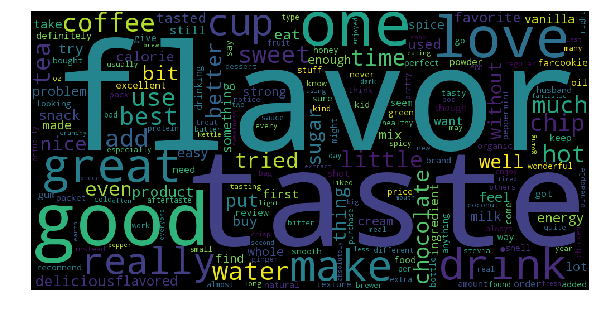

Cluster 4


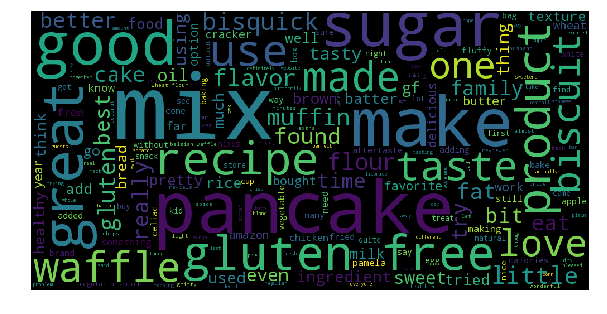

Cluster 6


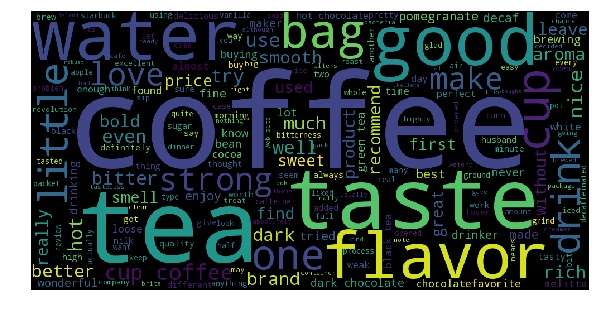

Cluster 8


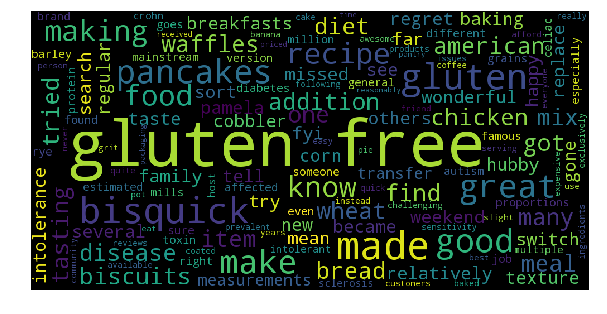

Cluster 10


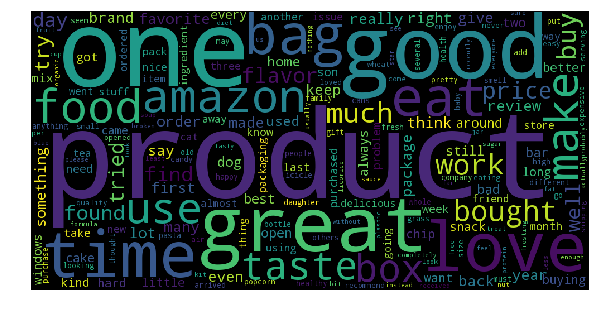

Cluster 12


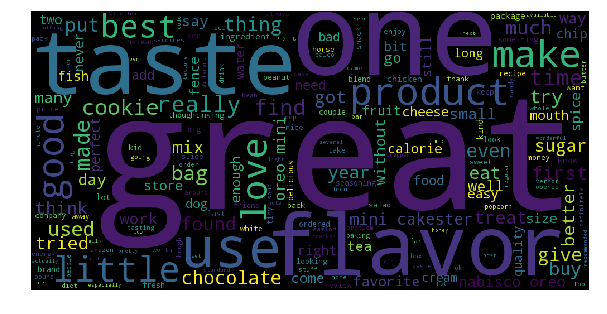

In [0]:
Word_Cloud(X_tfidfw2v, 50)

## Conclusions of K-means.

In [2]:
x = PrettyTable()
x.field_names = ["Vectorizer", " Clustering Model", "K", "Silhouette Score"]
x.add_row(['BOW', 'K-Means', 23, '0.0583'])
x.add_row(['TF-IDF', 'K-Means', 21, '0.0178'])
x.add_row(['Average W2V', 'K-Means',50, '0.1459'])
x.add_row(['TF-IDF Weighted W2V', 'K-Means', 50, '0.1679'])
print(x)

+---------------------+-------------------+----+------------------+
|      Vectorizer     |  Clustering Model | K  | Silhouette Score |
+---------------------+-------------------+----+------------------+
|         BOW         |      K-Means      | 23 |      0.0583      |
|        TF-IDF       |      K-Means      | 21 |      0.0178      |
|     Average W2V     |      K-Means      | 50 |      0.1459      |
| TF-IDF Weighted W2V |      K-Means      | 50 |      0.1679      |
+---------------------+-------------------+----+------------------+


# Agglomerative Clustering.

## [1] Average W2V

## With number of clusters as 10.

In [0]:
clustering = AgglomerativeClustering(n_clusters=10, affinity='euclidean', linkage='ward').fit(X_avgw2v)

## Now visualizing the clusters in 2-D and 3-D.

In [0]:
final_counts = X_avgw2v

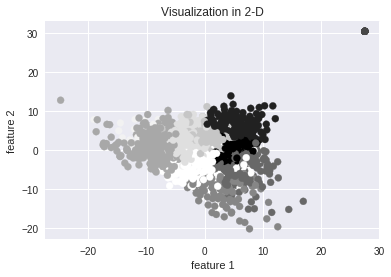

In [0]:
pca = PCA(n_components=2).fit(final_counts)
pca_2d = pca.transform(final_counts)
clustering = AgglomerativeClustering(n_clusters=10, affinity='euclidean', linkage='ward').fit(X_avgw2v)
plt.figure()
plt.scatter(pca_2d[:, 0], pca_2d[:, 1], c=clustering.labels_)
plt.title('Visualization in 2-D')
plt.ylabel('feature 2')
plt.xlabel('feature 1')
plt.show()


In [0]:
clustering = AgglomerativeClustering(n_clusters=10, affinity='euclidean', linkage='ward').fit(X_avgw2v)
centroids = k_means.cluster_centers_
X = X_avgw2v
y = clustering.labels_
print(X.shape)
print(y.shape)


(4986, 50)
(4986,)


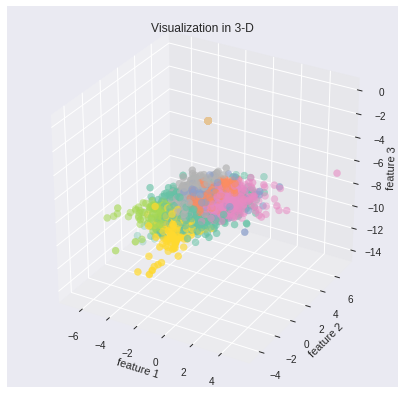

In [0]:
%matplotlib inline

#colors = ['navy', 'turquoise', 'darkorange']
plt.figure('K-Means on given Dataset', figsize=(7,7))
ax = plt.axes(projection = '3d')
ax.scatter(X[:,3],X[:,0],X[:,2], c=y , cmap='Set2', s=50)
plt.title('Visualization in 3-D')
ax.set_xlabel('feature 1')
ax.set_ylabel('feature 2')
ax.set_zlabel('feature 3')

plt.show()

##  Generting the word cloud for reviews for some of  the clusters.


In [0]:
def Word_Cloud(X, number_of_clusters):
  model = AgglomerativeClustering(n_clusters=number_of_clusters, affinity='euclidean', linkage='ward').fit(X_avgw2v)

  labels = list(model.labels_)
  for x in range(0, 5):
    def lists(x, labels):
      cluster = []
      for i in range(0, len(labels)):
        if labels[i]==x:
          cluster.append(i)
      return cluster
    datapoint_index = lists(x, labels)
    
    list_of_words = []
    for j in datapoint_index:
      for sent in preprocessed_reviews[j].split(' '):
        list_of_words.append(sent)
    print('Cluster'+' '+str(x+1))
    features_str = ' '.join(list_of_words)
    wordcloud = WordCloud(width = 1000, height = 500).generate(features_str)

    plt.figure(figsize=(10,10))
    plt.imshow(wordcloud)
    plt.axis("off")
    #plt.savefig("tfidf_RF"+".png", bbox_inches='tight')
    plt.show()
    plt.close()

Cluster 1


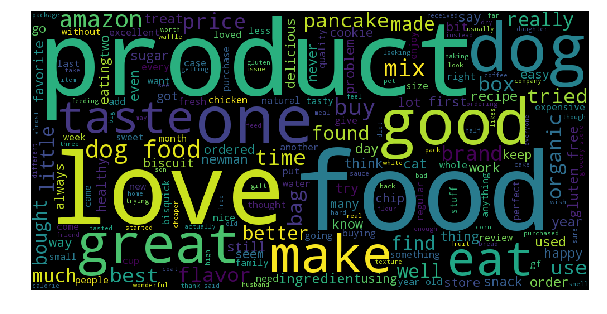

Cluster 2


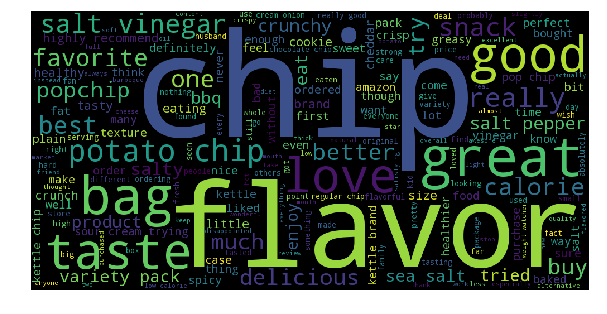

Cluster 3


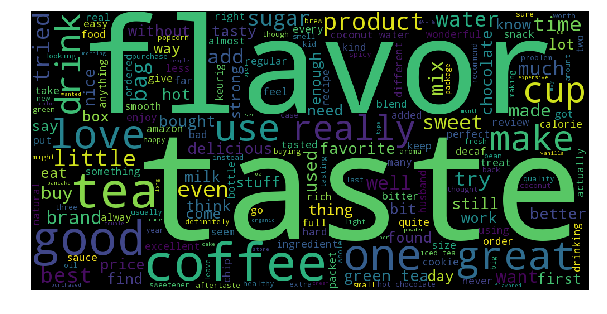

Cluster 4


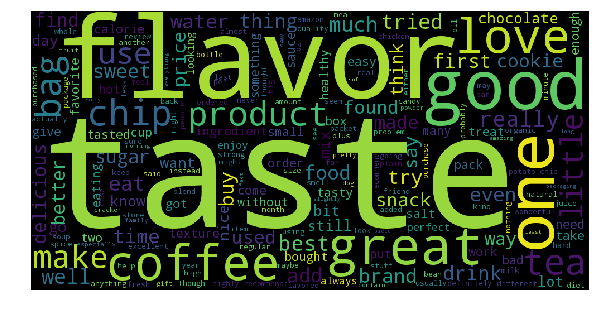

Cluster 5


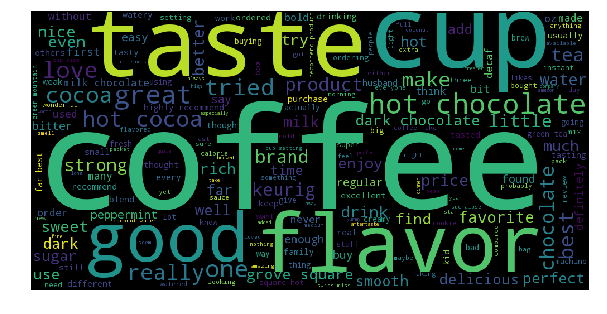

In [0]:
Word_Cloud(X_avgw2v, 10)

## With number of clusters as 25.

In [0]:
clustering = AgglomerativeClustering(n_clusters=25, affinity='euclidean', linkage='ward').fit(X_avgw2v)

## Now visualizing the clusters in 2-D and 3-D.

In [0]:
final_counts = X_avgw2v

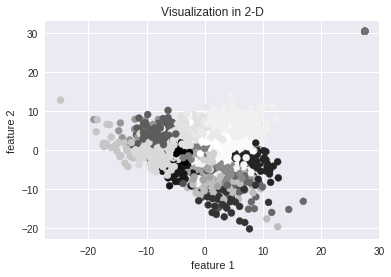

In [0]:
pca = PCA(n_components=2).fit(final_counts)
pca_2d = pca.transform(final_counts)
clustering = AgglomerativeClustering(n_clusters=25, affinity='euclidean', linkage='ward').fit(X_avgw2v)
plt.figure()
plt.scatter(pca_2d[:, 0], pca_2d[:, 1], c=clustering.labels_)
plt.title('Visualization in 2-D')
plt.ylabel('feature 2')
plt.xlabel('feature 1')
plt.show()


In [0]:
clustering = AgglomerativeClustering(n_clusters=25, affinity='euclidean', linkage='ward').fit(X_avgw2v)
centroids = k_means.cluster_centers_
X = X_avgw2v
y = clustering.labels_
print(X.shape)
print(y.shape)


(4986, 50)
(4986,)


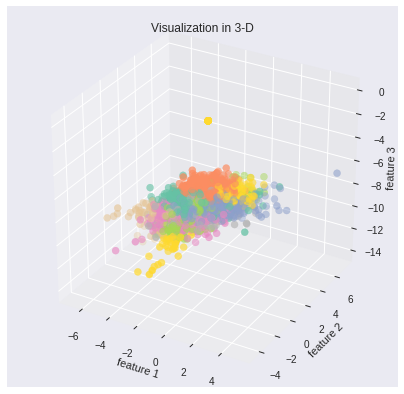

In [0]:
%matplotlib inline

#colors = ['navy', 'turquoise', 'darkorange']
plt.figure('K-Means on given Dataset', figsize=(7,7))
ax = plt.axes(projection = '3d')
ax.scatter(X[:,3],X[:,0],X[:,2], c=y , cmap='Set2', s=50)
plt.title('Visualization in 3-D')
ax.set_xlabel('feature 1')
ax.set_ylabel('feature 2')
ax.set_zlabel('feature 3')

plt.show()

##  Generting the word cloud for reviews for some of  the clusters.


In [0]:
def Word_Cloud(X, number_of_clusters):
  model = AgglomerativeClustering(n_clusters=number_of_clusters, affinity='euclidean', linkage='ward').fit(X_avgw2v)

  labels = list(model.labels_)
  for x in range(0, 5):
    def lists(x, labels):
      cluster = []
      for i in range(0, len(labels)):
        if labels[i]==x:
          cluster.append(i)
      return cluster
    datapoint_index = lists(x, labels)
    
    list_of_words = []
    for j in datapoint_index:
      for sent in preprocessed_reviews[j].split(' '):
        list_of_words.append(sent)
    print('Cluster'+' '+str(x+1))
    features_str = ' '.join(list_of_words)
    wordcloud = WordCloud(width = 1000, height = 500).generate(features_str)

    plt.figure(figsize=(10,10))
    plt.imshow(wordcloud)
    plt.axis("off")
    #plt.savefig("tfidf_RF"+".png", bbox_inches='tight')
    plt.show()
    plt.close()

Cluster 1


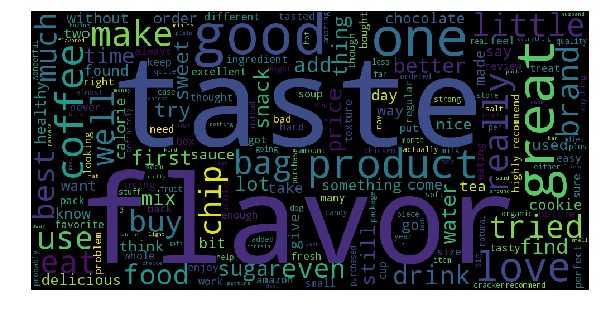

Cluster 2


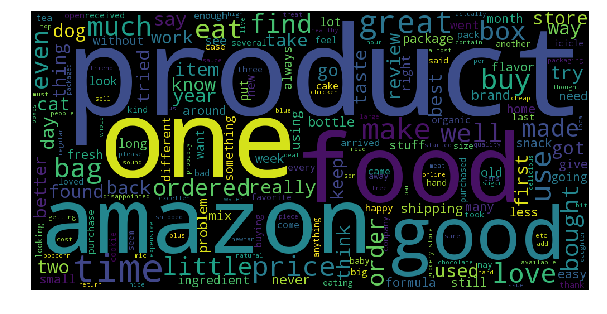

Cluster 3


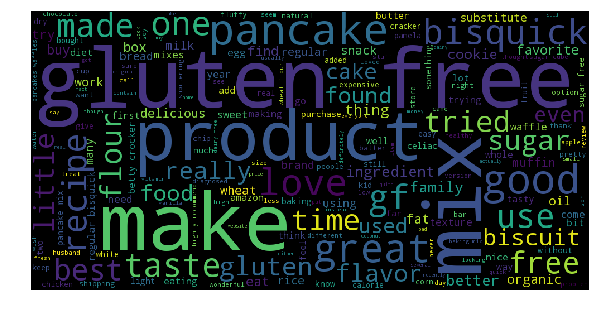

Cluster 4


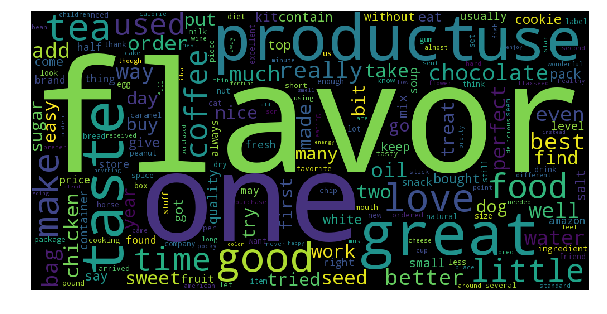

Cluster 5


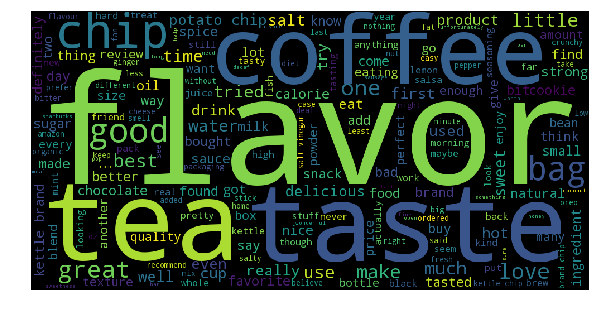

In [0]:
Word_Cloud(X_avgw2v, 25)

## [2] TF-IDF Weighted W2V

## With number of clusters as 10.

In [0]:
clustering = AgglomerativeClustering(n_clusters=10, affinity='euclidean', linkage='ward').fit(X_tfidfw2v)

## Now visualizing the clusters in 2-D and 3-D.

In [0]:
final_counts = X_tfidfw2v

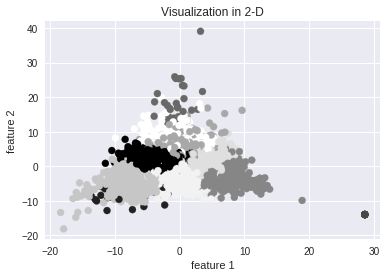

In [0]:
pca = PCA(n_components=2).fit(final_counts)
pca_2d = pca.transform(final_counts)
clustering = AgglomerativeClustering(n_clusters=10, affinity='euclidean', linkage='ward').fit(X_tfidfw2v)
plt.figure()
plt.scatter(pca_2d[:, 0], pca_2d[:, 1], c=clustering.labels_)
plt.title('Visualization in 2-D')
plt.ylabel('feature 2')
plt.xlabel('feature 1')
plt.show()

In [0]:
clustering = AgglomerativeClustering(n_clusters=10, affinity='euclidean', linkage='ward').fit(X_tfidfw2v)
centroids = k_means.cluster_centers_
X = X_avgw2v
y = clustering.labels_
print(X.shape)
print(y.shape)


(4986, 50)
(4986,)


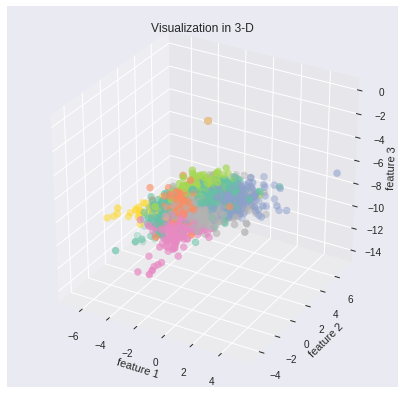

In [0]:
%matplotlib inline

#colors = ['navy', 'turquoise', 'darkorange']
plt.figure('K-Means on given Dataset', figsize=(7,7))
ax = plt.axes(projection = '3d')
ax.scatter(X[:,3],X[:,0],X[:,2], c=y , cmap='Set2', s=50)
plt.title('Visualization in 3-D')
ax.set_xlabel('feature 1')
ax.set_ylabel('feature 2')
ax.set_zlabel('feature 3')

plt.show()

##  Generting the word cloud for reviews for some of  the clusters.


In [0]:
def Word_Cloud(X, number_of_clusters):
  model = AgglomerativeClustering(n_clusters=number_of_clusters, affinity='euclidean', linkage='ward').fit(X)

  labels = list(model.labels_)
  for x in range(0, 5):
    def lists(x, labels):
      cluster = []
      for i in range(0, len(labels)):
        if labels[i]==x:
          cluster.append(i)
      return cluster
    datapoint_index = lists(x, labels)
    
    list_of_words = []
    for j in datapoint_index:
      for sent in preprocessed_reviews[j].split(' '):
        list_of_words.append(sent)
    print('Cluster'+' '+str(x+1))
    features_str = ' '.join(list_of_words)
    wordcloud = WordCloud(width = 1000, height = 500).generate(features_str)

    plt.figure(figsize=(10,10))
    plt.imshow(wordcloud)
    plt.axis("off")
    #plt.savefig("tfidf_RF"+".png", bbox_inches='tight')
    plt.show()
    plt.close()

Cluster 1


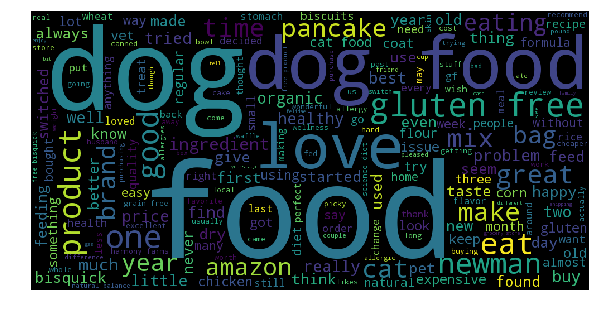

Cluster 2


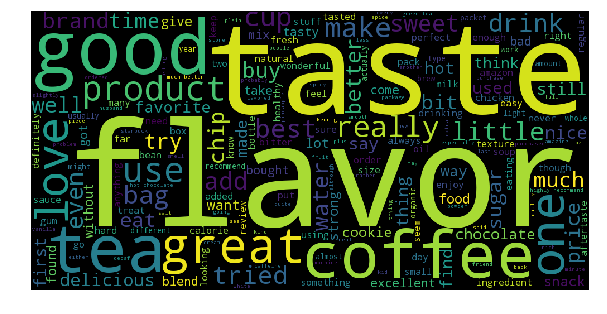

Cluster 3


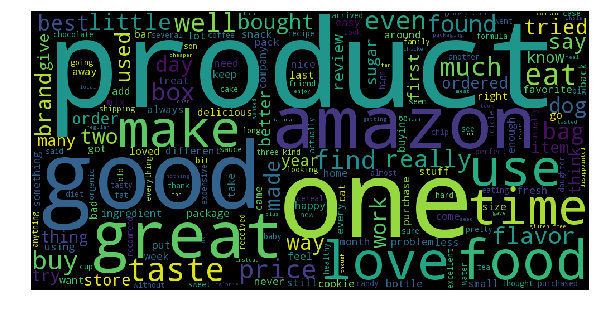

Cluster 4


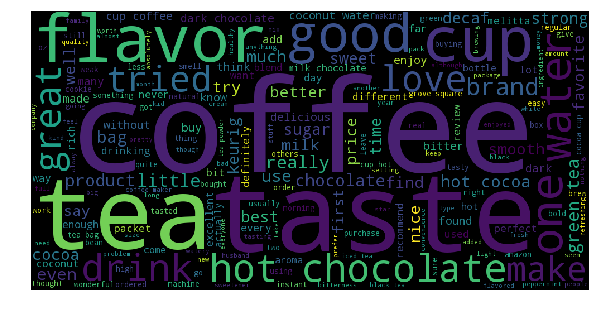

Cluster 5


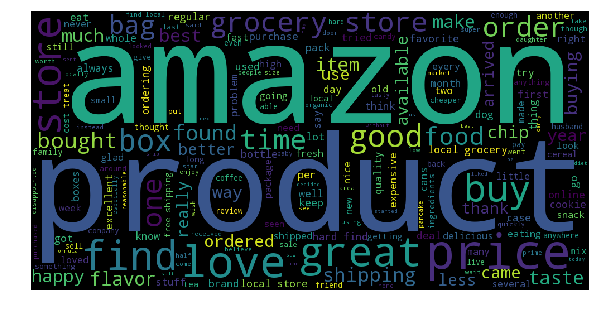

In [0]:
Word_Cloud(X_tfidfw2v, 10)

## With number of clusters as 25.

In [0]:
clustering = AgglomerativeClustering(n_clusters=25, affinity='euclidean', linkage='ward').fit(X_tfidfw2v)

## Now visualizing the clusters in 2-D and 3-D.

In [0]:
final_counts = X_tfidfw2v


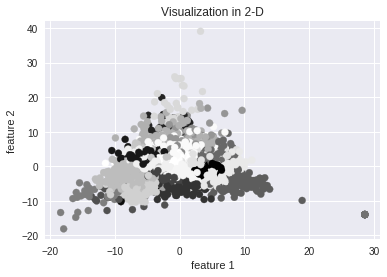

In [0]:
pca = PCA(n_components=2).fit(final_counts)
pca_2d = pca.transform(final_counts)
clustering = AgglomerativeClustering(n_clusters=25, affinity='euclidean', linkage='ward').fit(X_tfidfw2v)
plt.figure()
plt.scatter(pca_2d[:, 0], pca_2d[:, 1], c=clustering.labels_)
plt.title('Visualization in 2-D')
plt.ylabel('feature 2')
plt.xlabel('feature 1')
plt.show()


In [0]:
clustering = AgglomerativeClustering(n_clusters=25, affinity='euclidean', linkage='ward').fit(X_tfidfw2v)
centroids = k_means.cluster_centers_
X = X_avgw2v
y = clustering.labels_
print(X.shape)
print(y.shape)


(4986, 50)
(4986,)


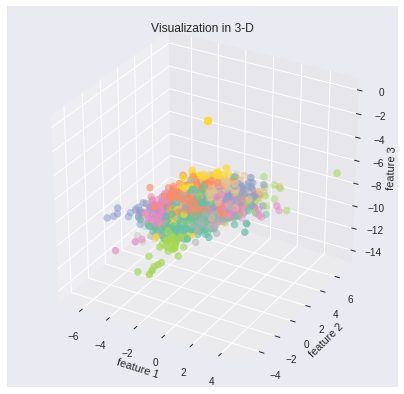

In [0]:
%matplotlib inline

#colors = ['navy', 'turquoise', 'darkorange']
plt.figure('K-Means on given Dataset', figsize=(7,7))
ax = plt.axes(projection = '3d')
ax.scatter(X[:,3],X[:,0],X[:,2], c=y , cmap='Set2', s=50)
plt.title('Visualization in 3-D')
ax.set_xlabel('feature 1')
ax.set_ylabel('feature 2')
ax.set_zlabel('feature 3')

plt.show()

##  Generting the word cloud for reviews for some of  the clusters.


In [0]:
def Word_Cloud(X, number_of_clusters):
  model = AgglomerativeClustering(n_clusters=number_of_clusters, affinity='euclidean', linkage='ward').fit(X)

  labels = list(model.labels_)
  for x in range(0, 5):
    def lists(x, labels):
      cluster = []
      for i in range(0, len(labels)):
        if labels[i]==x:
          cluster.append(i)
      return cluster
    datapoint_index = lists(x, labels)
    
    list_of_words = []
    for j in datapoint_index:
      for sent in preprocessed_reviews[j].split(' '):
        list_of_words.append(sent)
    print('Cluster'+' '+str(x+1))
    features_str = ' '.join(list_of_words)
    wordcloud = WordCloud(width = 1000, height = 500).generate(features_str)

    plt.figure(figsize=(10,10))
    plt.imshow(wordcloud)
    plt.axis("off")
    #plt.savefig("tfidf_RF"+".png", bbox_inches='tight')
    plt.show()
    plt.close()

Cluster 1


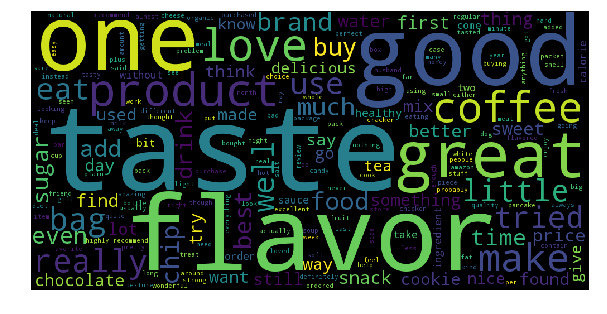

Cluster 2


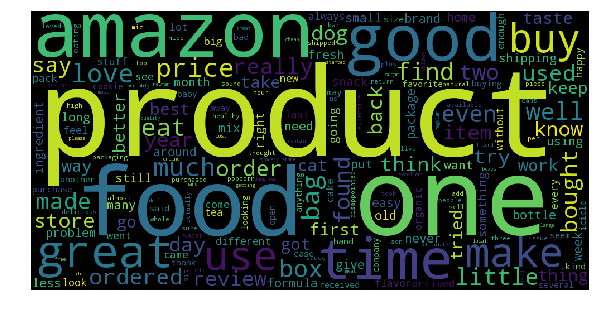

Cluster 3


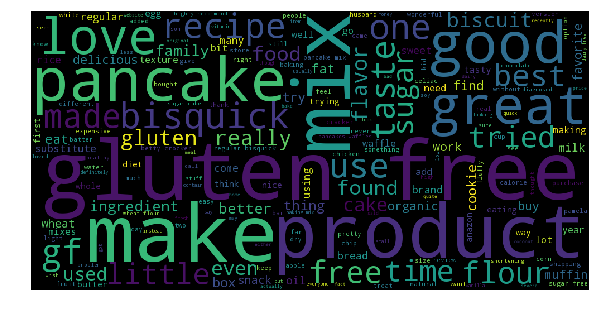

Cluster 4


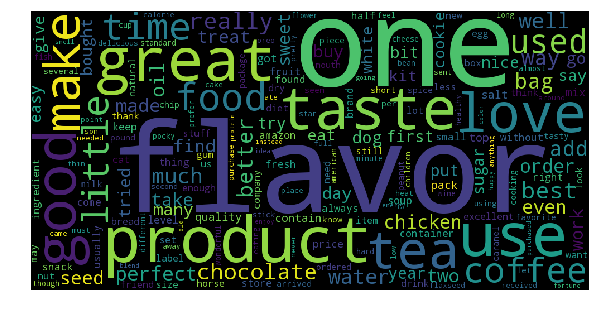

Cluster 5


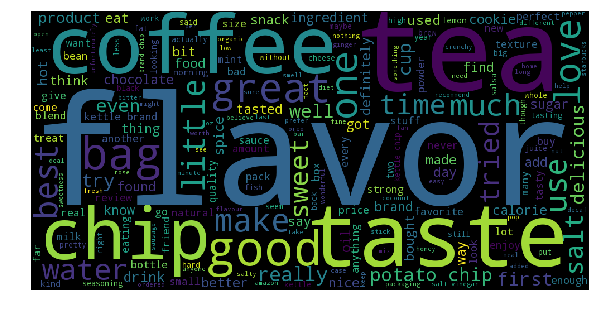

In [0]:
Word_Cloud(X_avgw2v, 25)

# **DBSCAN**

## [1] Average W2V

### As the dimensions of the vector is (4986, 50) i.e. every word is represented in 50 dimensions so optimal number of min_samples should be 51.

In [0]:
epsilons = [0.5, 1, 2, 3, 4, 5, 10, 20, 40]
core_points = []
for i in tqdm(epsilons):
  if i != 0:
    db = DBSCAN(eps=i, min_samples=51, n_jobs=-1).fit(X_avgw2v)
    core_points.append(np.size(db.core_sample_indices_))

100%|██████████| 9/9 [00:12<00:00,  1.33s/it]


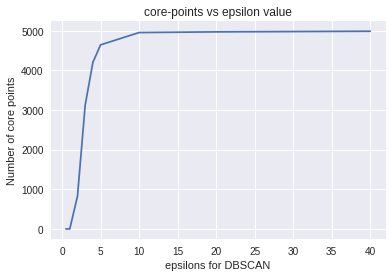

In [0]:
plt.plot(epsilons, core_points)
plt.title('core-points vs epsilon value')
plt.ylabel('Number of core points')
plt.xlabel('epsilons for DBSCAN')
plt.show()

### The above plot shows us the value of core points for different values of epsilons, as the number of core points increase, the noise decrease. Thus from the elbow method the optimal epsilon value should be chosen as 8.

In [0]:
db = DBSCAN(eps=8, min_samples=51, n_jobs=-1).fit(X_avgw2v)

### Now getting the silhouette_score.

In [0]:
clusterer = DBSCAN(eps=8, min_samples=51, n_jobs=-1)
cluster_labels = clusterer.fit_predict(X_avgw2v)
silhouette_avg = silhouette_score(X_avgw2v, cluster_labels)
print("The average silhouette_score is :", silhouette_avg)

The average silhouette_score is : 0.7743895908752205


## Now visualizing the clusters in 2-D and 3-D.

In [0]:
final_counts = X_avgw2v

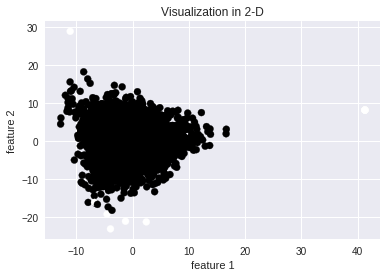

In [0]:
pca = PCA(n_components=2).fit(final_counts)
pca_2d = pca.transform(final_counts)
kmeans = DBSCAN(eps=8, min_samples=51, n_jobs=-1).fit(X_avgw2v)
kmeans.fit(final_counts)
plt.figure()
plt.scatter(pca_2d[:, 0], pca_2d[:, 1], c=kmeans.labels_)
plt.title('Visualization in 2-D')
plt.ylabel('feature 2')
plt.xlabel('feature 1')
plt.show()


In [0]:
k_means =  DBSCAN(eps=5, min_samples=51, n_jobs=-1)
k_means.fit(final_counts)
X = final_counts
y = k_means.labels_
print(X.shape)
print(y.shape)

(4986, 50)
(4986,)


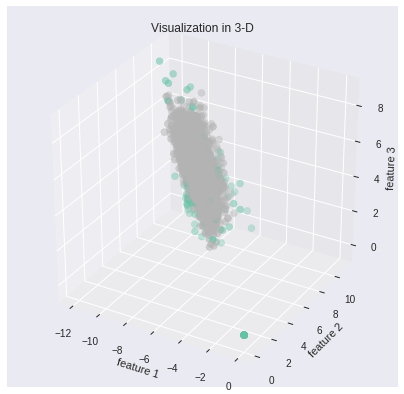

In [0]:
%matplotlib inline

#colors = ['navy', 'turquoise', 'darkorange']
plt.figure('K-Means on given Dataset', figsize=(7,7))
ax = plt.axes(projection = '3d')
ax.scatter(X[:,3],X[:,0],X[:,2], c=y , cmap='Set2', s=50)
plt.title('Visualization in 3-D')
ax.set_xlabel('feature 1')
ax.set_ylabel('feature 2')
ax.set_zlabel('feature 3')

plt.show()

##  Generting the word cloud for reviews for some of the clusters.


In [0]:
def Word_Cloud(X):
  model = DBSCAN(eps=8, min_samples=51, n_jobs=-1)
  model.fit(X)
  labels = list(model.labels_)
  print()
  a = [0]
  for x in a:
    def lists(x, labels):
      cluster = []
      for i in range(0, len(labels)):
        if labels[i]==x:
          cluster.append(i)
      return cluster
    datapoint_index = lists(x, labels)
    
    list_of_words = []
    for j in datapoint_index:
      for sent in preprocessed_reviews[j].split(' '):
        list_of_words.append(sent)
    print('Cluster'+' '+str(x+1))
    features_str = ' '.join(list_of_words)
    wordcloud = WordCloud(width = 1000, height = 500).generate(features_str)

    plt.figure(figsize=(10,10))
    plt.imshow(wordcloud)
    plt.axis("off")
    #plt.savefig("tfidf_RF"+".png", bbox_inches='tight')
    plt.show()
    plt.close()


Cluster 1


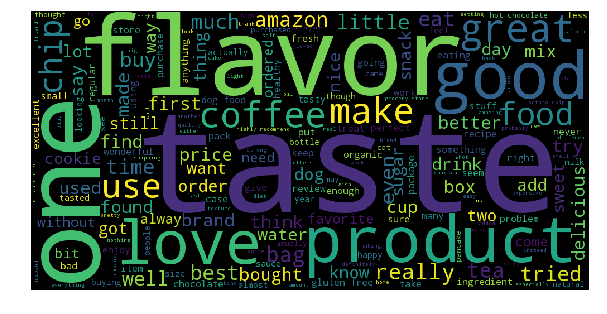

In [0]:
Word_Cloud(X_avgw2v)

## [2] TF-IDF Weighted W2V.

In [0]:
epsilons = [0.5, 1, 2, 3, 4, 5, 10, 20, 40]
core_points = []
for i in tqdm(epsilons):
  if i != 0:
    db = DBSCAN(eps=i, min_samples=51, n_jobs=-1).fit(X_tfidfw2v)
    core_points.append(np.size(db.core_sample_indices_))

100%|██████████| 9/9 [00:12<00:00,  1.28s/it]


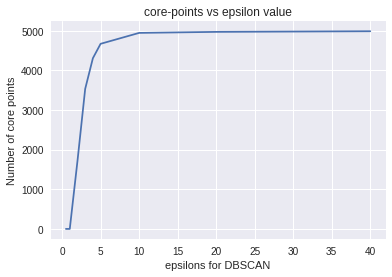

In [0]:
plt.plot(epsilons, core_points)
plt.title('core-points vs epsilon value')
plt.ylabel('Number of core points')
plt.xlabel('epsilons for DBSCAN')
plt.show()

### The above plot shows us the value of core points for different values of epsilons, as the number of core points increase, the noise decrease. Thus from the elbow method the optimal epsilon value should be chosen as 8.

In [0]:
db = DBSCAN(eps=8, min_samples=51, n_jobs=-1).fit(X_tfidfw2v)

### Now getting the silhouette_score.

In [0]:
clusterer = DBSCAN(eps=8, min_samples=51, n_jobs=-1)
cluster_labels = clusterer.fit_predict(X_tfidfw2v)
silhouette_avg = silhouette_score(X_tfidfw2v, cluster_labels)
print("The average silhouette_score is :", silhouette_avg)

The average silhouette_score is : 0.7105566554888426


## Now visualizing the clusters in 2-D and 3-D.

In [0]:
final_counts =X_tfidfw2v

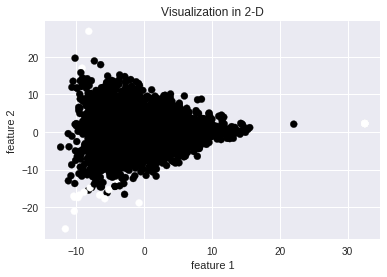

In [0]:
pca = PCA(n_components=2).fit(final_counts)
pca_2d = pca.transform(final_counts)
kmeans = DBSCAN(eps=8, min_samples=51, n_jobs=-1).fit(X_tfidfw2v)
kmeans.fit(final_counts)
plt.figure()
plt.scatter(pca_2d[:, 0], pca_2d[:, 1], c=kmeans.labels_)
plt.title('Visualization in 2-D')
plt.ylabel('feature 2')
plt.xlabel('feature 1')
plt.show()

In [0]:
k_means =  DBSCAN(eps=5, min_samples=51, n_jobs=-1)
k_means.fit(final_counts)
X = final_counts
y = k_means.labels_
print(X.shape)
print(y.shape)

(4986, 50)
(4986,)


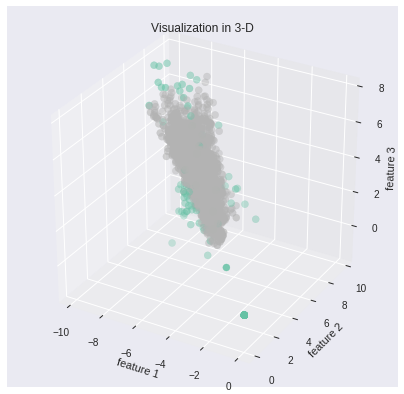

In [0]:
%matplotlib inline

#colors = ['navy', 'turquoise', 'darkorange']
plt.figure('K-Means on given Dataset', figsize=(7,7))
ax = plt.axes(projection = '3d')
ax.scatter(X[:,3],X[:,0],X[:,2], c=y , cmap='Set2', s=50)
plt.title('Visualization in 3-D')
ax.set_xlabel('feature 1')
ax.set_ylabel('feature 2')
ax.set_zlabel('feature 3')

plt.show()

##  Generting the word cloud for reviews for some of the clusters.


In [0]:
def Word_Cloud(X):
  model = DBSCAN(eps=8, min_samples=51, n_jobs=-1)
  model.fit(X)
  labels = list(model.labels_)
  print()
  a = [0]
  for x in a:
    def lists(x, labels):
      cluster = []
      for i in range(0, len(labels)):
        if labels[i]==x:
          cluster.append(i)
      return cluster
    datapoint_index = lists(x, labels)
    
    list_of_words = []
    for j in datapoint_index:
      for sent in preprocessed_reviews[j].split(' '):
        list_of_words.append(sent)
    print('Cluster'+' '+str(x+1))
    features_str = ' '.join(list_of_words)
    wordcloud = WordCloud(width = 1000, height = 500).generate(features_str)

    plt.figure(figsize=(10,10))
    plt.imshow(wordcloud)
    plt.axis("off")
    #plt.savefig("tfidf_RF"+".png", bbox_inches='tight')
    plt.show()
    plt.close()


Cluster 1


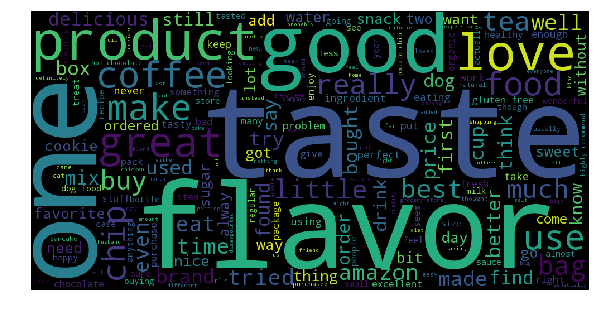

In [0]:
Word_Cloud(X_tfidfw2v)

## Conclusions of DBSCAN.

In [3]:
x = PrettyTable()
x.field_names = ["K-mean", "Clustering Model", "Min_samples", "Epsilon", "silhouette score"]
x.add_row(['Average W2V', 'DBSCAN',51, 8, '0.7743'])
x.add_row(['TF-IDF Weighted W2V', 'DBSCAN', 51, 8, '0.7105'])
print(x)

+---------------------+------------------+-------------+---------+------------------+
|        K-mean       | Clustering Model | Min_samples | Epsilon | silhouette score |
+---------------------+------------------+-------------+---------+------------------+
|     Average W2V     |      DBSCAN      |      51     |    8    |      0.7743      |
| TF-IDF Weighted W2V |      DBSCAN      |      51     |    8    |      0.7105      |
+---------------------+------------------+-------------+---------+------------------+
